# Computer Vision Coursework Submission (IN3060/INM460)

**Student name, ID and cohort:** Baber Abbasi (210002017) - PG


# Notebook Setup
In this section you should include all the code cells required to test your coursework submission. Specifically:

### Mount Google Drive

In [1]:
!pip install opencv-python==4.5.5.64 --quiet


     |████████████████████████████████| 60.5 MB 64 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
!pip install av

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 28.2 MB 1.5 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Define Local Path

In the next cell you should assign to the variable `GOOGLE_DRIVE_PATH_AFTER_MYDRIVE` the relative path of this folder in your Google Drive.

**IMPORTANT:** you have to make sure that **all the files required to test your functions are loaded using this variable** (as was the case for all lab tutorials). In other words, do not use in the notebook any absolute paths. This will ensure that the markers can run your functions. Also, **do not use** the magic command `%cd` to change directory.



In [4]:
import os

# TODO: Fill in the Google Drive path where you uploaded the CW_folder_PG
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_folder_PG'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = ''
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', 'Computer Vision Coursework/CW_Folder_PG')
print(os.listdir(GOOGLE_DRIVE_PATH))

['.DS_Store', 'Models', 'CW_Dataset', 'Code', 'Video', 'test_functions_scratch.ipynb']


### Load packages 

In the next cell you should load all the packages required to test your functions.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load
import os
import re
import av
import random
import numpy as np
import pandas as pd
import torch
import warnings
from tqdm.notebook import trange, tqdm
import imageio
from IPython.display import HTML
from base64 import b64encode
from skimage import io, color, img_as_ubyte
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import cv2
import torch.nn.functional as F
from skimage import io, transform
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from imutils.face_utils import FaceAligner
import math
import torch
import math
from PIL import Image
import av
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from collections import Counter
from skimage import io, transform, img_as_ubyte, color
import torch
import torch.nn as nn
from sklearn import svm, metrics
!pip install opencv-python==4.5.5.64 --quiet
from skimage.feature import hog

sns.set_style("whitegrid")

### Load models

In the next cell you should load all your trained models for easier testing of your functions. Avoid to load them within `EmotionRecognition` and `EmotionRecognitionVideo` to avoid having to reload them each time.

In [6]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(input_dim, 256),
      nn.ReLU(),
      nn.Linear(256, 128),
      nn.ReLU(),
      nn.Linear(128, output_dim)
    )

  def forward(self, x):
    '''Forward pass'''
    #batch_size = x.shape[0]
    #x = x.view(batch_size, -1)
    return self.layers(x)


class ConvNet1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*22*22, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7)
        # Define proportion or neurons to dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*22*22)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

HOG_MLP = MLP(1296, 7)
device = torch.device('cpu')
PATH = os.path.join(GOOGLE_DRIVE_PATH, 'Models','mlp-hog.pt')
HOG_MLP.load_state_dict(torch.load(PATH, map_location=device))

CNN = ConvNet1()
device = torch.device('cpu')
CNN.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH, 'Models/CNN_model.pt'), map_location=device))


SIFT_SVM = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models','svm_sift_model.joblib'))
KMEANS = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models','svm_sift_kmeans.joblib'))


# Test EmotionRecognition

This section should allow a quick test of the `EmotionRecognition` function. First, add cells with the code needed to load the necessary subroutines to make `EmotionRecognition` work.

In [7]:
# Function for CNN
def test4_CNN(X, Y, model):
    model.eval
    pred_list = []
    for i in X:
      model.eval()
      transform_ = transforms.Compose([
                          transforms.ToTensor(),                             
                          transforms.Normalize([0.5752, 0.4495, 0.4012], [0.2654, 0.2422, 0.2407])                             
                      ])
      i = transform_(i)
      with torch.no_grad():
          logits = model(i)
          _, predicted = torch.max(logits, 1)
          predicted = predicted.numpy()[0]
          pred_list.append(predicted)
    return pred_list


#Function for HOG_MLP
class DatasetHog(Dataset):
    #adapted from https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    """Images dataset for pytorch."""

    def __init__(self, descriptors, labels, transform=None):
        """
        Args:
            labels : Array of labels.
            descriptors (string): Array of HOG descriptors.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        #self.labels = pd.read_csv(
                                  #label_path,
                                  #delimiter=' ',
                                  #header=None,
                                  #names=['filename', 'label']
                                #)
        #self.root_dir = root_dir
        y = []
        for a in labels:
            x = a-1
            y.append(x)
        self.labels = y #convert labels to 0-6
        self.descriptors = descriptors
        self.transform = transform
        #self.image_path = sorted(os.listdir(root_dir))
        #self.transform = transforms.Compose(
                                #[transforms.Normalize(),
                                #transforms.ToTensor()]
                                #)
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #img_name = os.path.join(self.root_dir,
                                #self.labels.iloc[idx, 0])
        #image = io.imread(img_name)
        descriptors = self.descriptors[idx]
        #label = self.labels.iloc[idx, 1]
        label = self.labels[idx]
        

        if self.transform:
            image = self.transform(descriptors)
        
        return descriptors, label


def hog4(X, Y, model):
    hog_list_xtest = []
    p = []
    model_hog = HOG_MLP
    X_test = X
    y_test = Y
    for image in X:
        hos_descriptor =  hog(image,
                              orientations=9,
                              pixels_per_cell=(8, 8),
                              cells_per_block=(1, 1),
                              feature_vector = True,
                              visualize=False,
                              transform_sqrt=True,
                              multichannel=True)
        hog_list_xtest.append(hos_descriptor) 

    hog_list_xval = []

    dataset_hog_val = DatasetHog(hog_list_xtest, y_test)
    testloader_hog = DataLoader(dataset_hog_val, batch_size=4,
                            shuffle=False, num_workers=0)
    model.eval()
    with torch.no_grad():
      y_ = []
      for (x, y) in testloader_hog:

          x = x.float().to(device)
          #y = y.to(device)

          y_pred = model_hog(x)
          pred = torch.argmax(y_pred, dim=1)
          p.append(list(pred.cpu().numpy()))
          y_.append(y)

    return p[0]


sift = cv2.SIFT_create()
#Functions for HOG_MLP

def SVM4(X, Y, model, kmeans):
    X=X
    Y=Y
    svm = model

    hist_list = []
    for i in range(len(X)):
        img = img_as_ubyte(color.rgb2gray(X[i]))
        kp, des = sift.detectAndCompute(img, None)

        if des is not None:
            hist = np.zeros(70)

            idx = kmeans.predict(des)

            for j in idx:
                hist[j] = hist[j] + (1 / len(des))

            # hist = scale.transform(hist.reshape(1, -1))
            hist_list.append(hist)

        else:
            hist_list.append(None)

    # Remove potential cases of images with no descriptors
    idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
    hist_list = [hist_list[i] for i in idx_not_empty]
    # y_test = [y_test[i] for i in idx_not_empty]
    hist_array = np.vstack(hist_list)

    y_pred = svm.predict(hist_array).tolist()

    return y_pred



def EmotionRecognition(path_to_testset: str,
                       model_type: str,
                       label_path: str=
                       os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/list_label_test_edited.txt')):
    # Read the labels
    df = pd.read_csv(label_path,
                    delimiter=' ',
                    header=None,
                    names=['filename', 'label'])

    ground_truth = {
        0: 'Surprise',
        1: 'Fear',
        2: 'Disgust',
        3: 'Happiness',
        4: 'Sadness',
        5: 'Anger',
        6: 'Neutral', }

    # Sort the table by filename
    df.sort_values('filename', inplace=True)

    # Read and sort the directory for test images as well
    image_folder = sorted(os.listdir(path_to_testset))
    # Filter only images
    images_in_folder = [file for file in image_folder if file.endswith('.jpg')]

    # Get 4 random labels
    sample = df.sample(4)

    #image = io.imread(os.path.join(root_dir, imagepath))
    #images.append(image)

    X, Y = [], []
    for i in sample.index:
        y = df['label'][i]
        x = io.imread(os.path.join(path_to_testset, images_in_folder[i]))
        X.append(x)
        Y.append(y)

    if model_type == 'HOG_MLP':
        model = HOG_MLP
        y_pred = hog4(X, Y, model)
        Y = [x - 1 for x in Y]
    elif model_type == 'CNN':
        model = CNN
        y_pred = test4_CNN(X, Y, model)
        Y = [x - 1 for x in Y]
    elif model_type == 'SIFT_SVM':
        model = SIFT_SVM
        kmeans = KMEANS
        y_pred  = SVM4(X, Y, model, kmeans)

    fig, axes = plt.subplots(1, 4, figsize=(17, 4), sharex=True, sharey=True)
    ax = axes.ravel()
    for  i in range(4):
        ax[i].imshow((X[i]))
        ax[i].set_title(f'Target: {ground_truth[Y[i]]}\nLabel: {ground_truth[y_pred[i]]}')
        ax[i].set_axis_off()
    fig.tight_layout()
    plt.show()



Then, make a call to the `EmotionRecognition` function to see what results it produces. You must also indicate the syntax needed to test your different models.

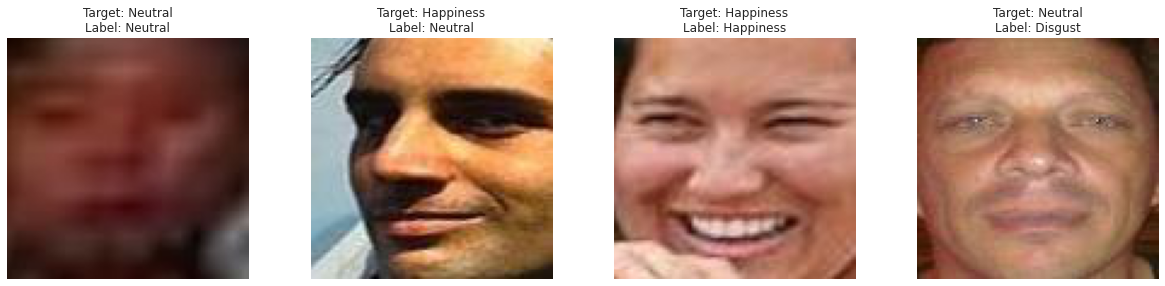

In [8]:
# Syntax for the next function is the following:
# 
# EmotionRecognition(path_to_testset, model_type)
# 
# where model_type can be one of
#   - 'SIFT_SVM'
#   - 'CNN'
#   - 'HOG_MLP'

path_to_testset = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/test')
EmotionRecognition(path_to_testset, 'CNN')

# Test EmotionRecognitionVideo

This section should allow a quick test of the `EmotionRecognitionVideo` function. First, add cells with the code needed to load the necessary subroutines to make `EmotionRecognitionVideo` work.

In [9]:
def EmotionRecognitionVideo(path: str = 'Video/elvis.mp4',
                            skip: int = 3,
                            save_path: str = 'elvis.mp4',
                            fps: int = 20,
                            ):
    """Return an array of images and array of labels.

        Args:
            path (string): Folder containing all the images. (default = 'Video/elvis.mp4')
            skip (int): Frames to skip for output video (default = 3)
            save_path (str): Save Path (relative to CV folder) (default = 'elvis.mp4')
            fps (int): Frame-rate for output video (default = 20)
    """
# code adapted from from https://github.com/serengil/tensorflow-101/blob/master/python/face-detection-complete-guide.py
# and https://github.com/serengil/tensorflow-101/blob/157faa9f58914987227d3f570b48c8afb9c64d78/python/face-alignment.py#L157
    # First some helper functions
    
    # Initializing the model
    label_dict = {
    0: 'Surprise',
    1: 'Fear',
    2: 'Disgust',
    3: 'Happiness',
    4: 'Sadness',
    5: 'Anger',
    6: 'Neutral', }

    model = CNN
    # Normalize pipeline for prediction
    transform_ = transforms.Compose([
                      transforms.ToTensor(),                             
                      transforms.Normalize([0.5752, 0.4495, 0.4012], [0.2654, 0.2422, 0.2407])                             
                   ])
    
    # Creating the facial recognition
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Get path to video file
    fpath = os.path.join(GOOGLE_DRIVE_PATH, path)
    container = av.open(fpath)
    original_frames = []
    # start video stream
    stream = container.streams.video[0]
    skip = skip #frames to skip
    index = -1
    for idx, frame in tqdm(enumerate(container.decode(stream)),
                           desc= 'Detecting Faces: ',
                           leave=False):
        if idx % skip == 0 or skip == 0:
            index += 1
            video = np.array(frame.to_image())
            original_frames.append([index,video]) # create a list of frames
            gray = cv2.cvtColor(video[...,::-1], cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, 1.3, 5)
            if len(faces) > 0: #if a face is detected
                for single_face in faces:
                    x,y,w,h = single_face
                    #if w > 130:
                    detected_face = video[int(y):int(y+h), int(x):int(x+w)] #crop detected face
                    detected_face = cv2.resize(detected_face, (100, 100)) #resize to 100x100
                    #detected_face = cv2.cvtColor(detected_face, cv2.COLOR_BGR2RGB) #convert to RGB
                    # create rectangle over detected face
                    original_frames[index][1] = cv2.rectangle(original_frames[index][1], (int(x), int(y)), (int(x+w), int(y+h)), (255, 0, 0), 2)
                    try: # try to predict
                        detected_face = transform_(detected_face)
                        model.eval()
                        with torch.no_grad():
                            logits = model(detected_face)
                            _, predicted = torch.max(logits, 1)
                            predicted = predicted.numpy()[0]
                            # add label to rectangle
                            cv2.putText(original_frames[index][1], label_dict[predicted], (int(x), int(y) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 0, 0), 2)
                    except: #if there's an error then just skip
                        pass
    with warnings.catch_warnings():
        writer = imageio.get_writer(save_path, fps=int(fps)) #writer
        for i, im in original_frames:
            writer.append_data(im)
        writer.close()
        #save output
        video_path = save_path
        # decode to HTML and play
        mp4 = open(video_path,'rb').read()
        decoded_vid = "data:video/mp4;base64," + b64encode(mp4).decode()
        return HTML(f'<video width=864 controls><source src={decoded_vid} type="video/mp4"></video>')

Then, make a call to the `EmotionRecognitionVideo` function to see what results it produces.

In [10]:
# Syntax for the next function is the following:
#
# EmotionRecognitionVideo(file)

EmotionRecognitionVideo('Video/elvis.mp4')

Output hidden; open in https://colab.research.google.com to view.